In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
from astropy import units as u
#import alipy

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
quasJ = [os.path.join('/media/lynge/Lynge-Back-up/ESO323/ESO323J/',f) \
        for f in os.listdir('/media/lynge/Lynge-Back-up/ESO323/ESO323J/')]

qua1_RA_WORLD = SkyCoord('13:06:26.115	-40:24:52.63', unit=(u.hourangle, u.deg)).ra.degree
qua1_DEC_WORLD = SkyCoord('13:06:26.115	-40:24:52.63', unit=(u.hourangle, u.deg)).dec.degree

print qua1_RA_WORLD

sta1_RA_WORLD = SkyCoord('13:06:23.368	-40:24:47.36', unit=(u.hourangle, u.deg)).ra.degree #TYC 7777-7-1
sta1_DEC_WORLD = SkyCoord('13:06:23.368	-40:24:47.36', unit=(u.hourangle, u.deg)).dec.degree

sta2_RA_WORLD = SkyCoord('13:06:20.816	-40:24:00.86', unit=(u.hourangle, u.deg)).ra.degree #2MASS J13062081-4024008
sta2_DEC_WORLD = SkyCoord('13:06:20.816	-40:24:00.86', unit=(u.hourangle, u.deg)).dec.degree

sta3_RA_WORLD = SkyCoord('13:06:31.543	-40:29:53.57', unit=(u.hourangle, u.deg)).ra.degree #UCAC2 14614825
sta3_DEC_WORLD = SkyCoord('13:06:31.543	-40:29:53.57', unit=(u.hourangle, u.deg)).dec.degree

sky_RA_WORLD = SkyCoord('13:06:25 -40:22:52', unit=(u.hourangle, u.deg)).ra.degree #Random patch of sky
sky_DEC_WORLD = SkyCoord('13:06:25 -40:22:52', unit=(u.hourangle, u.deg)).dec.degree

MAG_STA1_J = 10.513 
MAG_STA1_H = 10.226
MAG_STA1_K = 10.207

MAG_STA2_J = 8.294
MAG_STA2_H = 7.447
MAG_STA2_K = 7.105

MAG_STA3_J = 10.672
MAG_STA3_H = 10.142
MAG_STA3_K = 10.005

MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

MAG_VEGA_g = -0.08
MAG_VEGA_r = 0.16
MAG_VEGA_i = 0.37
MAG_VEGA_z = 0.54

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_LAMBDA_VEGA_g = 466.9*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_r = 278.0*10**(-11)
FLUX_LAMBDA_VEGA_i = 185.2*10**(-11)
FLUX_LAMBDA_VEGA_z = 131.5*10**(-11)


FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

FLUX_V_VEGA_g = 3.631*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_r = 3.631*10**(-20)
FLUX_V_VEGA_i = 3.631*10**(-20)
FLUX_V_VEGA_z = 3.631*10**(-20)


196.6088125


In [3]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [4]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [5]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [6]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    if 15 < x1 < header['NAXIS1'] - 15 and 15 < y1 < header['NAXIS2'] - 15:
        try:
            mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
            AGNdata[mask] = float(0)
            mask = AGNdata == 0.
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))
            AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
            #print apparature/float(pixspa)
        except:
            AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    else:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [7]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [8]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":5, 'DETECT_MINAREA':5, 'DETECT_MAXAREA':10000, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [9]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    header = pyfits.getheader(quas)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    output = float('nan')
    if 15 < RAmain < header['NAXIS1'] - 15 and 15 < DECmain < header['NAXIS2'] - 15: 
        out = SXtable(quas,aperture)
        RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[0]
        DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[1]
        #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
        #print RAmain, DECmain

        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 5. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 5. and \
            DECmain - 5. < out['table']['YMODEL_IMAGE'][j] < DECmain + 5.:
                #print 'YES'
                output = out['table']['FLUX_APER'][j]
                break
    else:
        output = float('nan')
        #print 'Done'
    return output


In [10]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(header['GAIN'])*data1_2*header['DIT']*header['NDIT']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['DIT']*header['NDIT'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['DIT']
                                                         *header['NDIT']
                                                         +header['NDIT']*npix1*header['RON']**2))

def SNR11(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(((header['GAIN'])*data1_2*header['DIT']*header['NDIT']))

def SNR22(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(header['GAIN']*npix1*data2_2*header['DIT']*header['NDIT'])

def SNR33(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float((header['NDIT']*npix1*header['RON']**2))

def SNR44(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(((header['GAIN'])*data1_2*header['DIT']*header['NDIT'] + 
                  header['GAIN']*npix1*data2_2*header['DIT']*header['NDIT'] +
                  header['NDIT']*npix1*header['RON']**2))

#SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

In [11]:
for i in range(len(quasJ)):
    data, header = fits.getdata(quasJ[i],header=True) #RA---TAN
    #print header['CTYPE2']
    #header['CTYPE1'] = "RA---TAN"
    #header['CTYPE2'] = "DEC--TAN"
    header['NDIT'] = 5
    '''header['A_ORDER'] = "0"
    header['B_ORDER'] = "0"
    header['AP_ORDER'] = "0"
    header['BP_ORDER'] = "0"
    header['A_0_2'] = "0"
    header['A_1_1'] = "0"
    header['A_2_0'] = "0"
    header['B_0_2'] = "0"
    header['B_1_1'] = "0"
    header['B_2_0'] = "0"
    header['AP_0_2'] = "0"
    header['AP_1_1'] = "0"
    header['AP_2_0'] = "0"
    header['AP_0_1'] = "0"
    header['AP_1_0'] = "0"
    header['BP_0_1'] = "0"
    header['BP_0_2'] = "0"
    header['BP_1_0'] = "0"
    header['BP_1_1'] = "0"
    header['BP_2_0'] = "0"'''
    fits.writeto(quasJ[i],data,header,clobber=True)
    #print fits.getheader(quasH[i])['A_ORDER']

In [12]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.003
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),7))
    SNR_array = np.zeros((len(quas),8))
    SNR_part = np.zeros((len(quas),5))
    gain = []
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i, quas[i]
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['DIT']
        #a_AGN_1 = flux(quas[i],2*aperture2,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        #a2_1 = flux(quas[i],2*aperture2,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        #a3_1 = flux(quas[i],2*aperture2,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        #a4_1 = flux(quas[i],2*aperture2,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a2_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky)
        a_sky_2 = np.sum(a_sky)/float(np.count_nonzero(a_sky))
        #a_AGN_pix_1 = np.pi*(2*aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a2_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a3_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a4_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = a_AGN/a_AGN_pix #- (a_AGN_1 - a_AGN)/(a_AGN_pix_1 - a_AGN_pix) #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix #- (a2_1 - a2)/(a2_pix_1 - a2_pix)
        a3_3 = a3/a3_pix #- (a3_1 - a3)/(a3_pix_1 - a3_pix)
        a4_3 = a4/a4_pix #- (a4_1 - a4)/(a4_pix_1 - a4_pix)
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        gain.append(header['gain'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        SNR1 = SNR(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        #flucompsta4.append(comp1(a_AGN_3,a5_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = date[i]
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        comp_array[i,4] = SNR1
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN,a2,a3,a4
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
        SNR_part[i,0] = date[i]
        SNR_part[i,1] = SNR(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,2] = SNR11(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,3] = SNR22(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,4] = SNR33(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
    #print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    
    comp_array[:,1] = comp_array[:,1]*flux_cal(MAG_STA1_J,MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    comp_array[:,2] = comp_array[:,2]*flux_cal(MAG_STA2_J,MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    comp_array[:,3] = comp_array[:,3]*flux_cal(MAG_STA3_J,MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_STA1_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_STA2_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta3)*flux_cal(MAG_STA3_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_STA1_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_STA2_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    ABS_FLUX_V_3 = np.array(flucompsta3)*flux_cal(MAG_STA3_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date,SNR_part

In [13]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1,SNR_part_1 = SEXAGNflux(quasJ,0.001)

Frame nr.  0 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
No handlers could be found for logger "sewpy.sewpy"


1944.229 2898.1 24451.24 nan
Frame nr.  1 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(1)
2046.227 3065.312 25587.2 nan
Frame nr.  2 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(10)
1491.362 2218.115 19203.93 nan
Frame nr.  3 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(11)
1579.588 2327.978 19680.37 nan
Frame nr.  4 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(12)
1212.015 1081.391 16293.2 nan
Frame nr.  5 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(13)
1461.441 2191.766 18019.65 1927.006
Frame nr.  6 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(14)
1597.216 2339.673 19249.82 2056.842
Frame nr.  7 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(15)
1749.975 2555.725 21623.84 1784.307
Frame nr.  8 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(16)
1542.004 2260.307 19373.08 1992.733
Frame nr.  9 /media/lynge/Lynge-Back-up/ESO323/ESO323J/ESO323_1_10_J.fits(17)
1738

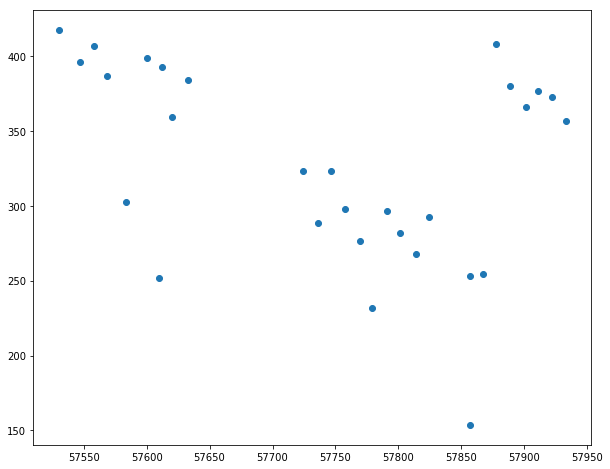

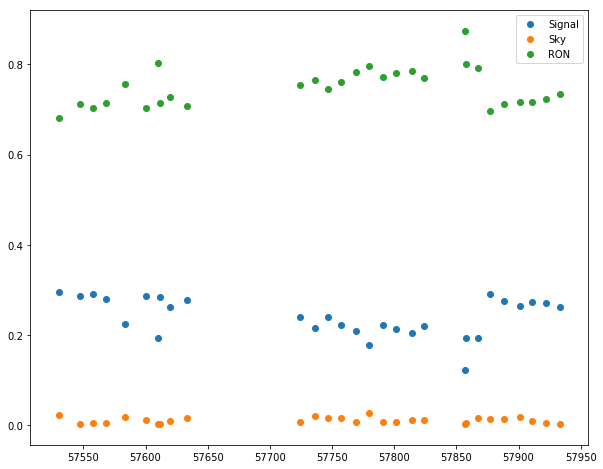

[ 356.61427159  372.36847558  281.95473012  296.77793375  231.47117702
  276.68912822  298.10693939  323.31926629  288.47341218  322.97303767
  384.24125763  359.53414345  376.30600107  392.6300962   251.91814666
  398.53140058  302.36911999  386.89638657  406.45704254  396.19914934
  417.55260568  366.15823003  380.01358416  407.95532005  254.42115196
  153.60226333  292.48794173  267.71329915  253.10115794]


In [14]:
plt.figure(figsize=(10,8))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,1])
plt.show()

plt.figure(figsize=(10,8))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,2],label='Signal')
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,3],label='Sky')
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,4],label='RON')
plt.legend()
#plt.ylim([5*10**(-15),1.*10**(-14)])
plt.show()

print SNR_part_1[:,1]
np.savetxt('../NOVEMBER/ESO323_SNR_J.txt',SNR_part_1)

In [15]:
COMB = np.ndarray.tolist(ABS_FLUX_LAMBDA_1_1) + np.ndarray.tolist(ABS_FLUX_LAMBDA_2_1) + np.ndarray.tolist(ABS_FLUX_LAMBDA_3_1)
datelist = date_1 + date_1 + date_1

COMB_array = np.array((datelist,COMB))
print COMB_array[0,:]
np.savetxt('J-NGC3783',COMB_array)

np.savetxt('../NOVEMBER/NOV-ESO323-J',comp_array)

[ 57933.147846  57922.147548  57801.318036  57791.199866  57779.323156
  57769.359112  57757.189682  57746.338386  57736.288188  57724.34546
  57633.007032  57620.079694  57911.031874  57612.000104  57610.132668
  57599.984598  57583.192992  57568.189094  57558.014746  57547.23345
  57530.075212  57901.059478  57888.315226  57877.3449    57867.152898
  57857.180168  57824.307832  57814.29831   57857.29559   57933.147846
  57922.147548  57801.318036  57791.199866  57779.323156  57769.359112
  57757.189682  57746.338386  57736.288188  57724.34546   57633.007032
  57620.079694  57911.031874  57612.000104  57610.132668  57599.984598
  57583.192992  57568.189094  57558.014746  57547.23345   57530.075212
  57901.059478  57888.315226  57877.3449    57867.152898  57857.180168
  57824.307832  57814.29831   57857.29559   57933.147846  57922.147548
  57801.318036  57791.199866  57779.323156  57769.359112  57757.189682
  57746.338386  57736.288188  57724.34546   57633.007032  57620.079694
  57911.

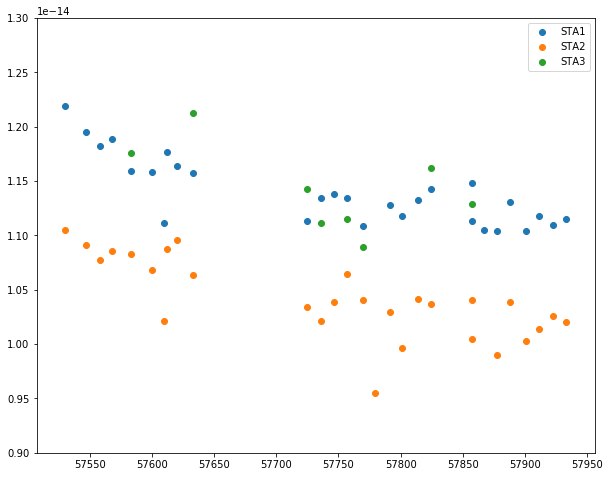

[  1.21924535e-14   1.19491576e-14   1.18185823e-14   1.18835802e-14
   1.15953385e-14   1.15849981e-14   1.11117798e-14   1.17670403e-14
   1.16407324e-14   1.15713725e-14   1.11293439e-14   1.13400459e-14
   1.13818922e-14   1.13476317e-14   1.10836766e-14   1.86303917e-14
   1.12787689e-14   1.11762410e-14   1.13241358e-14   1.14245079e-14
   1.14845565e-14   1.11311870e-14   1.10474188e-14   1.10403766e-14
   1.13062181e-14   1.10425743e-14   1.11772647e-14   1.10962407e-14
   1.11514359e-14]


In [19]:
plt.figure(figsize=(10,8))
plt.scatter(comp_array[:,0],comp_array[:,1],label='STA1')
plt.scatter(comp_array[:,0],comp_array[:,2],label='STA2')
plt.scatter(comp_array[:,0],comp_array[:,3],label='STA3')
plt.legend()
plt.ylim([9*10**(-15),1.3*10**(-14)])
plt.show()

print comp_array[:,1]

In [17]:
flucompsta1,flucompsta2,flucompsta3,flucompsta4,flucompsta5,flucompsta6,flucompsta7,\
SNR1,SNR2,SNR3,SNR4,SNR5,SNR_comp,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_V_1,\
ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529,SNR_test,file1,SNR_part \
= AGNflux(quasJ,0.001)

NameError: name 'AGNflux' is not defined

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(comp_array[:,0],comp_array[:,4])
plt.show()

print comp_array[:,4]

In [ ]:
plt.figure(figsize=(20,14))
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.85*10**(-14),1.4*10**(-14)])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57850,57880])
plt.legend()
plt.show()



In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,1])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,4])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,1])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,2])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,2])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,3])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,3])
plt.show()


In [ ]:
print np.argmax(SNR_test[:,1])

for i in range(len(file1)):
    print i, '{0:f}'.format(SNR_test[i,0]), '{0:f}'.format(SNR_test[i,1]), '{0:f}'.format(SNR_test[i,2])
    print file1[i]